# Learning `Deep Convolutional GAN`

In [1]:
%matplotlib inline

import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from dataset import ImageDataset

In [2]:
data_dir = 'datasets/flowers'
save_file = 'saved/data/flowers ({0}x{0}x{1}).pkl'

In [3]:
data = ImageDataset(data_dir=data_dir, size=25, flatten=True, grayscale=True)

if not os.path.isfile(save_file.format(data.size, data.channel)):
    data.create()
    data.save(save_file.format(data.size, data.channel), force=True)
else:
    data = data.load(save_file.format(data.size, data.channel))

Processing 5 of 5 class labels & 799 of 799 images

In [4]:
X_train, y_train, X_test, y_test = data.train_test_split(test_size=0.1)

(3670, 625) 1


In [5]:
print(f'X_train.shape = {X_train.shape}')
print(f'X_test.shape = {X_test.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'y_test.shape = {y_test.shape}')

X_train.shape = (3303, 625)
X_test.shape = (367, 625)
y_train.shape = (3303, 5)
y_test.shape = (367, 5)


### Helper function tot plot images and labels

In [12]:
# Helper function to plot images and labels.
def imshow(images, labels, pred=None, **kwargs):
    
    # images => shape: [batch_size, img_size, img_size, img_channel]
    
    # Keyword arguments.
    smooth = kwargs.get('smooth', True)
    
    # Image dimensions.
    img_shape = images.shape
    img_size = img_shape[1]
    img_channel = img_shape[-1] if len(img_shape) > 3 else 1
    img_batch = img_shape[0]
    
    # Log number of images to be shown.
    print(f'Showing {img_batch:,} images')
    
    # Create figure with sub-plots.
    fig, axes = plt.subplots(4, 4)

    # Adjust vertical spacing if we need to print ensemble and best-net.
    wspace, hspace = 0.2, 0.8 if pred is not None else 0.4
    fig.subplots_adjust(hspace=hspace, wspace=wspace)

    for i, ax in enumerate(axes.flat):
        try:
            # cmap type.
            cmap = 'Greys' if img_channel == 1 else None

            # Interpolation type.
            smooth = 'spline16' if smooth else 'nearest'

            # Reshape image based on channel.
            if img_channel == 1:
                img = np.reshape(images[i], newshape=(img_size, img_size))
            else:
                img = np.transpose(images[i], (1, 2, 0))

            # Plot image.
            ax.imshow(img, interpolation=smooth, cmap=cmap)

            # Name of the true class.
            labels_name = data.classes[np.argmax(labels[i])]

            # Show true and predicted classes.
            if pred is None:
                xlabel = f'True: {labels_name}'
            else:
                # Name of the predicted class.
                pred_name = data.classes[np.argmax(pred[i])]

                xlabel = f'True: {labels_name}\nPred: {pred_name}'

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)

            # Remove ticks from the plot.
            ax.set_xticks([])
            ax.set_yticks([])
        except IndexError:
            break
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

Showing 2 images


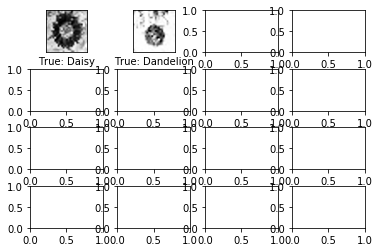

In [13]:
img = np.reshape(X_test[:2], newshape=[-1, data.size, data.size, data.channel])
labels = y_test[:2]
imshow(img, labels)

### Plot a random image

In [9]:
y_test[0].shape

(5,)

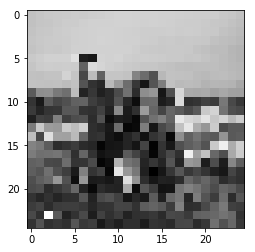

In [5]:
# Take random image sample.


for b in range(batch_size):
    idx = np.random.randint(0, len(y_test))
    img = X_test[idx]
    label = y_test[idx]
    
    sample_image.append([])
    
sample_image = [(X_test[i], y_test) for _ in range(batch_size)]

# Reshape it.
sample_image = sample_image.reshape([data.size, data.size])

# Plot the image.
plt.imshow(sample_image, cmap='gray')
plt.show()

## Hyperparams

In [6]:
# Inputs.
img_size = data.size
img_channel = data.channel
img_size_flat = img_size * img_size * img_channel

# Network.
conv_filter = 5
deconv_filter = 3
strides = [1, 2, 2, 1]
conv_1 = 16
conv_2 = 32
fc_1_size = 1024
fc_2_size = 1

# Training.
learning_rate = 1e-3
batch_size = 24
iterations = 10_000
save_interval = 50
viz_interval = 200

## Building the Network

### Helper functions

In [7]:
# Weight initializer
def weight(shape, layer_name):
    return tf.get_variable(layer_name, shape, initializer=tf.truncated_normal_initializer(stddev=0.2))

# Bias initializer
def bias(shape, layer_name):
    return tf.get_variable(layer_name, [shape], initializer=tf.constant_initializer(0))

# Convolutional block
def conv_block(layer, W, b):
    layer = tf.nn.conv2d(layer, W, strides=[1, 1, 1, 1], padding='SAME')
    layer = layer + b  # add bias
    layer = tf.nn.relu(layer)
    layer = tf.nn.max_pool(layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    return layer

# Deconvolutional block
def deconv_block(layer, W, b, activation_fn=tf.nn.relu, batch_norm=None):
    layer = tf.nn.conv2d(layer, W, strides=[1, 2, 2, 1], padding='SAME')
    layer = layer + b
    if batch_norm:
        layer = tf.contrib.layers.batch_norm(layer, epsilon=1e-5, scope=batch_norm)
    layer = activation_fn(layer)
    return layer

# Fully connected layer
def fully_connected(layer, W, b, use_relu=True):
    layer = tf.matmul(layer, W) + b
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

# Flatten layer
def flatten(layer):
    shape = layer.get_shape()
    features = np.array(shape[1:4], dtype=np.int32).prod()
    flattened = tf.reshape(layer, [-1, features])
    return flattened, features

### Discriminator `(Deep Convolutional neural net)`

In [8]:
def discriminator(image, reuse=None):
    with tf.variable_scope(tf.get_variable_scope(), reuse=reuse) as scope:
        # 1st convolutional block
        d_conv_W1 = weight(shape=[conv_filter, conv_filter, img_channel, conv_1], layer_name='d_conv_W1')
        d_conv_b1 = bias(shape=conv_1, layer_name='d_conv_b1')
        d_conv_1 = conv_block(image, d_conv_W1, d_conv_b1)
        # 2nd convolutional block
        d_conv_W2 = weight(shape=[conv_filter, conv_filter, conv_1, conv_2], layer_name='d_conv_W2')
        d_conv_b2 = bias(shape=conv_2, layer_name='d_conv_b2')
        d_conv_2 = conv_block(d_conv_1, d_conv_W2, d_conv_b2)
        # Flatten layer
        flattened, features = flatten(d_conv_2)
        # 1st Fully connected layer
        d_fc_W1 = weight(shape=[features, fc_1_size], layer_name='d_fc_W1')
        d_fc_b1 = bias(shape=fc_1_size, layer_name='d_fc_b1')
        fc_1 = fully_connected(flattened, d_fc_W1, d_fc_b1, use_relu=True)
        # 2nd Fully connected layer
        d_fc_W2 = weight(shape=[fc_1_size, fc_2_size], layer_name='d_fc_W2')
        d_fc_b2 = bias(shape=fc_2_size, layer_name='d_fc_b2')
        fc_2 = fully_connected(fc_1, d_fc_W2, d_fc_b2, use_relu=False)
        return fc_2

### Generator `(Deep Deconvolutional neural net)`

In [9]:
def generator(z, batch_size, z_dim):
    scale = img_size * 2
    up_scale = scale * scale
    # 1st Deconvolutional block
    g_deconv_W1 = weight(shape=[z_dim, up_scale], layer_name='g_deconv_W1')
    g_deconv_b1 = bias(shape=up_scale, layer_name='g_deconv_b1')
    g_deconv_1 = tf.matmul(z, g_deconv_W1) + g_deconv_b1
    g_deconv_1 = tf.reshape(g_deconv_1, [-1, scale, scale, img_channel])
    g_deconv_1 = tf.contrib.layers.batch_norm(g_deconv_1, epsilon=1e-5, scope='bn_G1')
    g_deconv_1 = tf.nn.relu(g_deconv_1)
    # 2nd Deconvolutional block
    g_deconv_W2 = weight(shape=[deconv_filter, deconv_filter, img_channel, z_dim//2], layer_name='g_deconv_W2')
    g_deconv_b2 = bias(shape=z_dim//2, layer_name='g_deconv_b2')
    g_deconv_2 = deconv_block(g_deconv_1, g_deconv_W2, g_deconv_b2, batch_norm='bn_G2')
    g_deconv_2 = tf.image.resize_images(g_deconv_2, [scale, scale])
    # 3rd Deconvolutional block
    g_deconv_W3 = weight(shape=[deconv_filter, deconv_filter, z_dim//2, z_dim//4], layer_name='g_deconv_W3')
    g_deconv_b3 = bias(shape=z_dim//4, layer_name='g_deconv_b3')
    g_deconv_3 = deconv_block(g_deconv_2, g_deconv_W3, g_deconv_b3, batch_norm='bn_G3')
    g_deconv_3 = tf.image.resize_images(g_deconv_3, [scale, scale])
    # Final Deconvolutional block
    g_deconv_W4 = weight(shape=[1, 1, z_dim//4, 1], layer_name='g_deconv_W4')
    g_deconv_b4 = bias(shape=1, layer_name='g_deconv_b4')
    g_deconv_4 = deconv_block(g_deconv_3, g_deconv_W4, g_deconv_b4, activation_fn=tf.nn.sigmoid)
    return g_deconv_4

In [30]:
y_test[:3]

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [10]:
# Clear default graph caches and start a new one.
tf.reset_default_graph()

# Generator network input dimensions.
z_dim = 100
z_placeholder = tf.placeholder(tf.float32, [None, z_dim])

In [11]:
# Pass the placeholder through the generator network.
gen_img = generator(z_placeholder, 1, z_dim)

# Get one random batch for testing.
z_batch = np.random.normal(0, 1, [1, z_dim])

Test image shape = (1, 25, 25, 1)


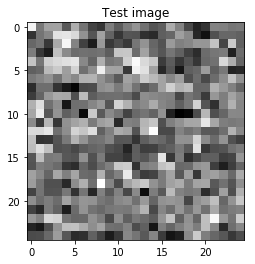

In [12]:
# Initialize model variables.
init = tf.global_variables_initializer()    

# Start the TensorFlow's Session.
with tf.Session() as sess:
    sess.run(init)
    
    # Run the generator.
    test_img = sess.run(gen_img, feed_dict={z_placeholder: z_batch})
    
    print(f'Test image shape = {test_img.shape}')
    
    plt.title('Test image')
    plt.imshow(test_img.reshape([img_size, img_size]), cmap='gray')
    plt.show()

In [13]:
tf.reset_default_graph()

# Placeholder variables.
z_placeholder = tf.placeholder(tf.float32, [None, z_dim], name='z_placeholder')
X_placeholder = tf.placeholder(tf.float32, [None, img_size_flat], name='X_placeholder')
X_image = tf.reshape(X_placeholder, [-1, img_size, img_size, img_channel])

# Generator network.
Gz = generator(z_placeholder, batch_size, z_dim)

## Discriminator network. ##
# Prob. for real img:
Dx = discriminator(X_image)

# Prob. for generated img:
Dg = discriminator(Gz, reuse=True)

### Loss functions

In [14]:
# Discriminator loss
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dx, labels=tf.ones_like(Dx)))
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Dg, labels=tf.zeros_like(Dg)))

# Generator loss
g_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Dg, labels=tf.ones_like(Dg)))

### Retrieve Trainable Vars

In [17]:
# Get the model trainable variables.
t_vars = tf.trainable_variables()

# Split the generator and discriminator by name scope.
d_vars = [var for var in t_vars if 'd_' in var.name]
g_vars = [var for var in t_vars if 'g_' in var.name]

print(', '.join([var.name for var in d_vars]), end='\n\n')
print(', '.join([var.name for var in g_vars]))

d_conv_W1:0, d_conv_b1:0, d_conv_W2:0, d_conv_b2:0, d_fc_W1:0, d_fc_b1:0, d_fc_W2:0, d_fc_b2:0

g_deconv_W1:0, g_deconv_b1:0, g_deconv_W2:0, g_deconv_b2:0, g_deconv_W3:0, g_deconv_b3:0, g_deconv_W4:0, g_deconv_b4:0


### Optimization

In [18]:
# Discriminator optimization.
d_opt_real = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_real, var_list=d_vars)
d_opt_fake = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(d_loss_fake, var_list=d_vars)

## Generator optimization. ##

# Global step for the generator.
g_global_step = tf.Variable(0, trainable=False)

# Optimizer for the generator.
g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Minimize the loss i.e. train the Generator.
g_train = g_opt.minimize(g_loss, var_list=g_vars, global_step=g_global_step)

## Tensorboard stuff

In [20]:
# Start the TensorFlow's Session.
sess = tf.Session()
sess.run(tf.global_variables_initializer())

# Henceforth, reuse variables
tf.get_variable_scope().reuse_variables()

# Scalar summaries.
tf.summary.scalar('Generator_Loss', g_loss)
tf.summary.scalar('Discriminator_Loss_Real', d_loss_real)
tf.summary.scalar('Discriminator_Loss_Fake', d_loss_fake)

# Image summaries
img_4_tensorboard = generator(z_placeholder, batch_size, z_dim)
tf.summary.image('Generated_Images', img_4_tensorboard, max_outputs=5)

# Merge all summaries.
merged = tf.summary.merge_all()

# Parent save directory.
save_dir = 'saved/learning-gan'

# Tensorboard directory.
tensorboard_dir = os.path.join(save_dir, 'tensorboard')
logdir = os.path.join(tensorboard_dir, 'log')

# Model saved directory.
model_dir = os.path.join(save_dir, 'models')
save_path = os.path.join(model_dir, 'model.ckpt')

# Model sver and tensorboard writer object.
saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir=logdir, graph=sess.graph)

In [23]:
# Restoring TensorFlow's Session.
if tf.gfile.Exists(model_dir):
    try:
        print('INFO: Attempting to load last checkpoint.')
        
        # Get the last checkpoint.
        last_ckpt = tf.train.latest_checkpoint(checkpoint_dir=model_dir)
        saver.restore(sess=sess, save_path=last_ckpt)
        
        print(f'SUCCESS: Successfully restored Session at {last_ckpt}')
    except Exception as e:
        # Print error message.
        sys.stderr.write(f'ERR: Could not load checkpoint. {e}')
        sys.stderr.flush()
else:
    # Create the checkpiont folder.
    tf.gfile.MakeDirs(model_dir)

    print(f'INFO: Created checkpoint folder: {model_dir}')

INFO: Attempting to load last checkpoint.
INFO:tensorflow:Restoring parameters from saved/learning-gan/models/model.ckpt


ERR: Could not load checkpoint. {e}

In [25]:
# Start the training time.
train_start = dt.datetime.now()

# Pre-train discriminator.
for t in range(100):
    try:
        # Load real image batch.
        real_img_batch = data.next_batch(batch_size)[0]
        
        # Load fake image batch.
        fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])

        # Discriminator's feed dict.
        feed_dict = {X_placeholder: real_img_batch, z_placeholder: fake_img_batch}
        
        # Load real image batch.
        real_img_batch = data.next_batch(batch_size)[0]

        # Train the discriminator: to classifiy real from fake.
        _, _, _d_real, _d_fake = sess.run([d_opt_fake, d_opt_real, d_loss_real, d_loss_fake], 
                                          feed_dict=feed_dict)
        
        # Log progress!
        sys.stdout.write(f'\rIterations: {t+1:,}\td_loss_real: {_d_real:.4f}\td_loss_fake: {_d_fake:.4f}'
                         f'\tTraining: {dt.datetime.now() - train_start:}')
        
    except KeyboardInterrupt:
        print('Training stopped.')
        
        # Save the session.
        saver.save(sess=sess, save_path=save_path)

        print('Session saved!')
        
        break

Iterations: 100	d_loss_real: 1610.9664	d_loss_fake: 0.8962	Training: 0:00:15.216899 ago


	Iterations: 1 at Thu Mar 22, 2018 at 18:50:06 PM


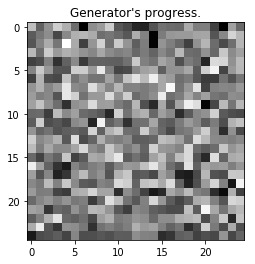

Discriminator's estimate = [[-13.60187]]

Iter: 19	Train time: 0:00:10.226982	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000Training iterrupted!

TRAINING SUMMARY:
	Iterations: 20	Training time: 0:00:10.464262
	d_loss_fake: 0.0000	d_loss_real: 0.0000	g_loss: 0.0000



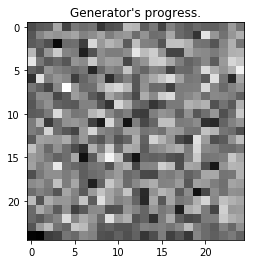

Discriminator's estimate = [[-13.455461]]



In [27]:
# Start the discriminator and generator training clock.
train_start = dt.datetime.now()


# Generator's feed dict. Z is drawn from a normal distribution.
# Usage: g_feed_dict(batch_size) or g_feed_dict(batch_size, z_dim) or g_feed_dict(1)
g_feed_dict = lambda x, y=z_dim: {z_placeholder: np.random.normal(0, 1, size=[x, y])}


# Train generator & discriminator together (dual each other).
for t in range(iterations):
    try:
        
        # Load real image batch.
        real_img_batch = data.next_batch(batch_size)[0]
        
        # Load fake image batch.
        fake_img_batch = np.random.normal(0, 1, [batch_size, z_dim])
        
        # Discriminator's feed dict.
        feed_dict = {X_placeholder: real_img_batch, z_placeholder: fake_img_batch}
        
        # Train the discriminator.
        _, _, _d_real, _d_fake = sess.run([d_opt_fake, d_opt_real, d_loss_real, d_loss_fake], 
                                          feed_dict=feed_dict)
        
        # Train the generator.
        _, _gen_loss, _g_global = sess.run([g_train, g_loss, g_global_step], 
                                           feed_dict=g_feed_dict(batch_size))
        
        # Save model and Update tensorboard at intervals.
        if t % save_interval == 0:
            # Save model chkpt.
            saver.save(sess=sess, save_path=save_path, global_step=g_global_step)
            
            # Update tensorboard summary.
            summary = sess.run(merged, feed_dict=feed_dict)
            writer.add_summary(summary=summary, global_step=_g_global)
        
        # Visualize generators progress at intervals.
        if t % viz_interval == 0:
            # Every 1000 iterations, show a generated image
            print(f"\n\tIterations: {t+1:,} at {dt.datetime.now():%a %h %d, %Y at %H:%M:%S %p}")
            
            # Pass random image to the generator to do it's thing:
            gen_imgs = generator(z_placeholder, 1, z_dim)
            
            # Generate images.
            images = sess.run(gen_imgs, feed_dict=g_feed_dict(1, z_dim))
            
            # Plot the generated image.
            plt.imshow(images[0].reshape([img_size, img_size]), cmap='Greys')
            plt.title("Generator's progress.")
            plt.show()
            
            # Show discriminator's estimate.
            result = discriminator(tf.reshape(X_placeholder, [-1, img_size, img_size, img_channel]))
            img = np.reshape(images[0], newshape=[-1, img_size_flat])
            estimate = sess.run(result, feed_dict={X_placeholder: img})
            
            print(f"Discriminator's estimate = {estimate}\n")
        
        # Log training progress.
        sys.stdout.write(f'\rIter: {t+1:,}\tTrain time: {dt.datetime.now() - train_start:}'
                         f'\td_loss_fake: {_d_fake:.4f}\td_loss_real: {_d_real:.4f}\tg_loss: {_gen_loss:.4f}')
    
    # When training is stopped by user.
    except KeyboardInterrupt:
        print('\n\nTraining iterrupted!\n\nTRAINING SUMMARY:')
        print(f'\tIterations: {t+1:,}\tGlobal: {_g_global:,}\n'
              f'\tTraining time: {dt.datetime.now() - train_start:}\n'
              f'\td_loss_fake: {_d_fake:.4f}\td_loss_real: {_d_real:.4f}'
              f'\tg_loss: {_gen_loss:.4f}\n')
        
        # Visualize summary.
        # Pass random image to the generator to do it's thing:
        gen_imgs = generator(z_placeholder, 1, z_dim)
        
        # Generate new images.
        images = sess.run(gen_imgs, g_feed_dict(1, z_dim))
        
        # Plot a generated image.
        plt.imshow(images[0].reshape([img_size, img_size]), cmap='Greys')
        plt.title("Generator's progress.")
        plt.show()
        
        # Show discriminator's estimate.
        result = discriminator(tf.reshape(X_placeholder, [-1, img_size, img_size, img_channel]))
        estimate = sess.run(result, {X_placeholder: np.reshape(images[0], [-1, img_size_flat])})

        print(f"Discriminator's estimate = {estimate}\n")
        
        # Save model chkpt.
        saver.save(sess=sess, save_path=save_path, global_step=g_global_step)

        # Update tensorboard summary.
        summary = sess.run(merged, feed_dict=feed_dict)
        writer.add_summary(summary=summary, global_step=_g_global)
        
        # End training iteration.
        break
        
    finally:
        # Flush the standard output buffer.
        sys.stdout.flush()